In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from random import choice
import random
import networkx as nx
import os
from pandas.io.json import json_normalize
import collections
import warnings
warnings.filterwarnings('ignore')

In [35]:
# SET CHANNEL PREFERENCES
connectedness_percentile = 90
num_channels_to_make = 10
channel_capacity_sats = 20000

In [36]:
# FUNCTIONS

# GET THE MAIN GRAPH
def get_main_subgraph(G):
    all_sub_G = list(nx.connected_component_subgraphs(G))
    largest_sg = 0
    for i, sg in enumerate(all_sub_G):
        if sg.number_of_nodes() > largest_sg:
            largest_sg = sg.number_of_nodes()
            main_G = sg
    return main_G


# RETURN NODES with highest percentile of degree centrality
def find_nodes_high_percentile_deg_cent(G, connectedness_percentile):
    # Compute the degree centrality of G: deg_cent      
    deg_cent = nx.degree_centrality(G)
    # Compute the X percentile of degree centrality
    dc = list(deg_cent.values())
    high_percentile_dc = np.percentile(dc, connectedness_percentile)
    nodes = set()
    # Iterate over the degree centrality dictionary
    for k, v in deg_cent.items():
        # Check if the current value has the maximum degree centrality
        if v > high_percentile_dc:
            # Add the current node to the set of nodes
            nodes.add(k)
    return nodes


# CONNECT TO SELECTED NODES
def connect_to_new_neighbors(new_neighbors):
    for i in range(len(new_neighbors)):

        print("Setting up payment channel with "+node_alias[i]+"\n");
        connect = lightning_dir+"lightning-cli connect "+new_neighbors[i]+"@"+ip_address[i]
        print(connect)
    #     os.system(connect);

        fund_channel = lightning_dir+"lightning-cli fundchannel "+new_neighbors[i]+" "+str(channel_capacity_sats)
        print(fund_channel)
        print("\n")
    #     os.system(fund_channel);
    
    
    
# PICK NEW NEIGHBORS
def pick_new_neighbors(G, connectedness_percentile, num_channels_to_make):
    # Remove disconnected nodes
    G = get_main_subgraph(G)
    # Find nodes within top X% of highest centrality
    potential_neighbors = list(find_nodes_high_percentile_deg_cent(G, connectedness_percentile))
    # pick new neighbors
    new_neighbors = random.sample(potential_neighbors, num_channels_to_make)
    return new_neighbors

# DISPLAY NEW NEIGHBOR INFO
def display_new_neighbors(G, new_neighbors):
    print("Do you want to connect to the following nodes?\n\n")
    node_alias=[]; num_channels=[]; ip_address=[]

    for i in range(len(new_neighbors)):
        nd = nodes_table[nodes_table['nodeid']==new_neighbors[i]]
        node_alias.append(str(nd['alias']))
        num_channels.append(len(list(G.neighbors(new_neighbors[i]))))
        ip_address.append(list(nd['addresses'])[0][0]['address'])
        print("node ID: "+new_neighbors[i])
        print("node alias: "+node_alias[i])
        print("number of channels: "+str(num_channels[i])+"\n")

In [37]:
# GET DATA
lightning_dir = "~/lightning/cli/"
save_dir = "> /Users/dariuscognac/Documents/GitHub/Lightning-Network-Topological-Analysis/"
listnodes = lightning_dir + "lightning-cli listnodes" + save_dir + "list_of_nodes.json"
listchannels = lightning_dir + "lightning-cli listchannels" + save_dir + "list_of_channels.json"

# os.system(listnodes);
# os.system(listchannels);


# LOAD AND FORMAT DATA
nodes_temp = pd.read_json('list_of_nodes.json')
nodes_table = json_normalize(nodes_temp['nodes'])
channels_temp = pd.read_json('list_of_channels.json')
channels_table = json_normalize(channels_temp['channels'])


# MAKE GRAPH
G = nx.Graph()
G.add_nodes_from(nodes_table['nodeid'])
edges_list = [(channels_table['source'][i], channels_table['destination'][i]) for i in range(len(channels_table))]
G.add_edges_from(edges_list)

G = get_main_subgraph(G)

print('Number of nodes = ' + str(len(G.nodes())))
print('Number of edges (payment channels) = ' + str(len(G.edges())))
print('\n\n')


Number of nodes = 1191
Number of edges (payment channels) = 4915





In [39]:
new_neighbors = pick_new_neighbors(G, connectedness_percentile, num_channels_to_make)

display_new_neighbors(G, new_neighbors)

Do you want to connect to the following nodes?


node ID: 025cb2d324ae423d32984c7fc74edd7185b9fc9bd473d389f12483e3738d526600
node alias: 564    Hong Kong Lightning Hub
Name: alias, dtype: object
number of channels: 42

node ID: 032679fec1213e5b0a23e066c019d7b991b95c6e4d28806b9ebd1362f9e32775cf
node alias: 2756    LNBIG.com [lnd-03]
Name: alias, dtype: object
number of channels: 67

node ID: 03baa70886d9200af0ffbd3f9e18d96008331c858456b16e3a9b41e735c6208fef
node alias: 556    LIGHTNING
Name: alias, dtype: object
number of channels: 29

node ID: 026c7d28784791a4b31a64eb34d9ab01552055b795919165e6ae886de637632efb
node alias: 1310    LivingRoomOfSatoshi.com_LND_1
Name: alias, dtype: object
number of channels: 25

node ID: 03bc9337c7a28bb784d67742ebedd30a93bacdf7e4ca16436ef3798000242b2251
node alias: 838    LNBIG.com [lnd-06]
Name: alias, dtype: object
number of channels: 35

node ID: 039edc94987c8f3adc28dab455efc00dea876089a120f573bd0b03c40d9d3fb1e1
node alias: 2162    LNBIG.com [lnd-32]
Na

In [40]:
# CREATE NEW GRAPH WITH NEW NODE AND EDGES
G_new = G.copy()
G_new.add_node('new_node')
new_edges = [('new_node',i) for i in new_neighbors]
G_new.add_edges_from(new_edges)


In [41]:
# PLOTTING FUNCTIONS

def plot_ego_graph(new_node_id, G, centrality_measure):
    # Create ego graphs
    ego_graph = nx.ego_graph(G, new_node_id, radius=2)
    immediate_graph = nx.ego_graph(G, new_node_id, radius=1)

    fig = plt.figure(3,figsize=(12,8)) 
    pos=nx.spring_layout(ego_graph, seed=1)

    centrality_dict = get_centrality_dict(G, centrality_measure)

    # Draw larger extended network 
    graph1_color_vals = [centrality_dict.get(node) for node in ego_graph.nodes()]

    nx.draw_networkx_nodes(ego_graph, pos=pos, cmap=plt.get_cmap('viridis'), 
            node_color=graph1_color_vals, node_size=100, alpha=0.6)
    nx.draw_networkx_edges(ego_graph, pos=pos, alpha=0.3, edge_color='grey')


    # Draw immediate network with stronger alpha
    graph2_color_vals = [centrality_dict.get(node) for node in immediate_graph.nodes()]

    nx.draw(immediate_graph, pos=pos, cmap=plt.get_cmap('viridis'), with_labels = False, 
            node_color=graph2_color_vals, node_size=400, alpha=1, edge_color='k', width = 5)

    
    # Create label for new node
    labels = {}    
    for node in immediate_graph.nodes():
        if node == new_node_id:
            #set the node name as the key and the label as its value 
            labels[node] = 'X'

    # offset new label
    offset =0
#     offset =-.1
    pos_labels = {}
    keys = pos.keys()
    for key in keys:
        x, y = pos[key]
        pos_labels[key] = (x, y+offset)
    nx.draw_networkx_labels(immediate_graph, pos_labels, labels, font_size=16, font_color='r', font_weight='bold')
    
    
    node_channel_num = G.degree(new_node_id)
    node_bet_cent = nx.betweenness_centrality(G).get(new_node_id)
    node_closeness = nx.closeness_centrality(G).get(new_node_id)
    

    textstr = '\n'.join((
    r'Num channels=%d' % (node_channel_num),
    r'Betweenness=%.2E' % (node_bet_cent),
    r'Closeness=%.2f' % (node_closeness)))
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax = fig.gca()
    plt.text(1.2, 0, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

#     plt.text(1.8, 0.3, textstr, horizontalalignment='center',
#     verticalalignment='center', transform=ax.transAxes)
    
    
    plt.show()

    
def get_centrality_dict(G, centrality_measure):
    switcher = {
        'degree': dict(nx.degree(G)) ,
        'betweenness': nx.betweenness_centrality(G),
        'closeness': nx.closeness_centrality(G)
    }
    return switcher.get(centrality_measure)


def plot_centrality_hist(fig, ax, G, centrality_measure, new_node_id):
    centrality_dict = get_centrality_dict(G, centrality_measure)
    plt.hist(centrality_dict.values(),bins=25)
    ax.set_yscale('log')
    
    node_centrality_value = centrality_dict.get(new_node_id)
    display(node_centrality_value)
    type(node_centrality_value)
    ax.axvline(x=node_centrality_value, color='r')
#     plt.show()

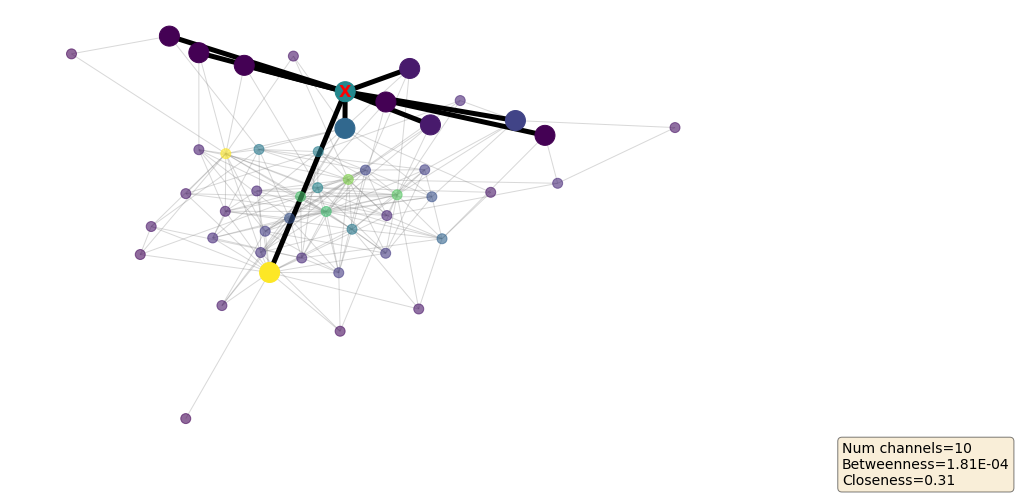

In [34]:
plot_ego_graph('new_node', G_new, centrality_measure='degree')

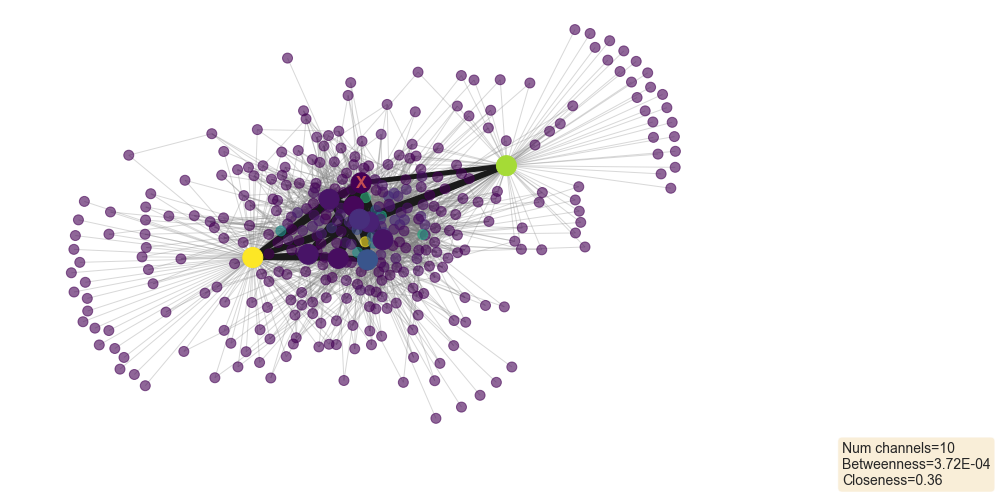

In [45]:
plot_ego_graph('new_node', G_new, centrality_measure='betweenness')

In [ ]:
plot_ego_graph('new_node', G_new, centrality_measure='closeness')

10

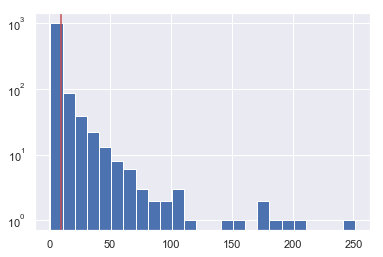

In [71]:
fig, ax = plt.subplots()
plot_centrality_hist(fig, ax, G_new, centrality_measure='degree', new_node_id='new_node')
plt.show()

0.0003715103567622596

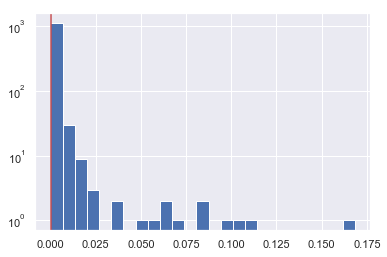

In [72]:
fig, ax = plt.subplots()
plot_centrality_hist(fig, ax, G_new, centrality_measure='betweenness', new_node_id='new_node')
plt.show()

0.3647779479326187

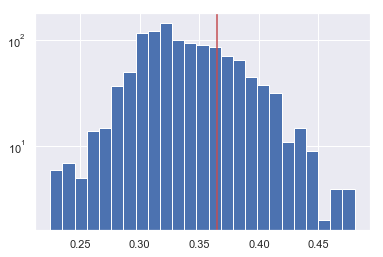

In [73]:
fig, ax = plt.subplots()
plot_centrality_hist(fig, ax, G_new, centrality_measure='closeness', new_node_id='new_node')
plt.show()

In [ ]:
connect_to_new_neighbors(new_neighbors)